In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 1.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch

<ipython-input-2-d1db268a5ed1>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [3]:
# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the pixel values to range [0, 1] and reshape for CNN
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# One-hot encode the labels
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Define the CNN model function for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
                     kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.25, max_value=0.5, step=0.25)))

    model.add(Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=128, step=32),
                     kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.25, max_value=0.5, step=0.25)))

    model.add(Flatten())
    model.add(Dense(hp.Int('dense_1_units', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.25, max_value=0.5, step=0.25)))
    model.add(Dense(10, activation='softmax'))  # Output layer with 10 units for 10 digits

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [6]:
# Hyperparameter optimization using Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='random_search',
    project_name='mnist_tuning'
)

# Search for the best hyperparameters
tuner.search(train_images, train_labels, epochs=20, validation_split=0.1, callbacks=[early_stop, reduce_lr])

Trial 5 Complete [00h 03m 08s]
val_accuracy: 0.9961666464805603

Best val_accuracy So Far: 0.9961666464805603
Total elapsed time: 00h 18m 00s


In [7]:
# Get the best model and summary of search results
best_model = tuner.get_best_models(num_models=1)[0]
tuner.results_summary()

# Train the best model
best_model.fit(train_images, train_labels, batch_size=128, epochs=100, validation_split=0.1, callbacks=[checkpoint, early_stop, reduce_lr])

Results summary
Results in random_search/mnist_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
conv_1_filters: 32
dropout_1: 0.25
conv_2_filters: 64
dropout_2: 0.5
dense_1_units: 256
dropout_3: 0.25
Score: 0.9961666464805603

Trial 1 summary
Hyperparameters:
conv_1_filters: 128
dropout_1: 0.5
conv_2_filters: 128
dropout_2: 0.25
dense_1_units: 256
dropout_3: 0.25
Score: 0.9953333139419556

Trial 2 summary
Hyperparameters:
conv_1_filters: 64
dropout_1: 0.25
conv_2_filters: 64
dropout_2: 0.25
dense_1_units: 256
dropout_3: 0.25
Score: 0.9946666955947876

Trial 0 summary
Hyperparameters:
conv_1_filters: 64
dropout_1: 0.5
conv_2_filters: 128
dropout_2: 0.5
dense_1_units: 64
dropout_3: 0.25
Score: 0.9934999942779541

Trial 3 summary
Hyperparameters:
conv_1_filters: 128
dropout_1: 0.25
conv_2_filters: 96
dropout_2: 0.25
dense_1_units: 64
dropout_3: 0.5
Score: 0.9929999709129333
Epoch 1/100
422/422 [==============================] 

In [8]:
# Evaluate the best model on the test set
test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print(f'Test accuracy of the best model: {test_acc}')

313/313 [==============================] - 1s 3ms/step - loss: 0.0232 - accuracy: 0.9940
Test accuracy of the best model: 0.9940000176429749


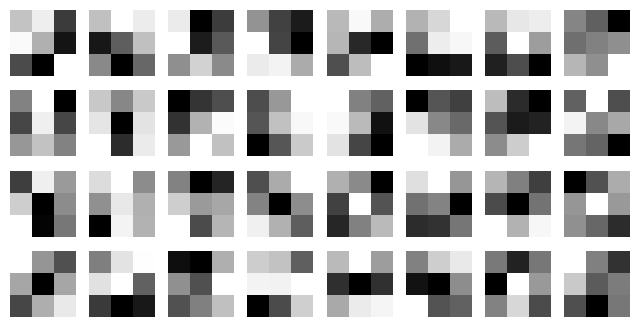

In [9]:
# Visualize filters learned by the first convolutional layer
first_layer_weights = best_model.layers[0].get_weights()[0]
plt.figure(figsize=(8, 4))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(first_layer_weights[:, :, 0, i], cmap='gray')
    plt.axis('off')
plt.show()